In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#from sklearn import OneHotEncoder

# per importare cose nella folder precedente da ora in poi
import sys
sys.path.append('../')

from layer import HiddenLayer
from activations import *
from losses import *
from network import Network
from regularizers import *
from utils import *
from metrics import *
from validation import *
from gridsearch import grid_search

random.seed(42)
np.random.seed(42)

# Progress bar
from tqdm import tqdm
import time

In [2]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

In [3]:
from sklearn.preprocessing import MinMaxScaler
rescaler = MinMaxScaler()
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
rescaler.fit(y_train)
y_train = rescaler.transform(y_train)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [11]:
seed = 3
np.random.seed(seed)
net = Network(MSE(1), eta=1e-3)

net.add_layer(
    input_size=len(X_train[0]),
    units_size=32,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-8),
    activation=ReLU(),
    momentum=('Nesterov', 0.9),
)

net.add_layer(
    input_size=32,
    units_size=32,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-8),
    activation=ReLU(),
    momentum=('Nesterov', 0.9),
)

net.add_layer(
    input_size=32,
    units_size=3,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-8),
    activation=Identity(),
    momentum=('Nesterov', 0.9),
)

In [4]:
X_split = np.array_split(X_train, 5)
y_split = np.array_split(y_train, 5)

X_train = np.concatenate(X_split[:4] + (X_split[4 + 1:]))
y_train = np.concatenate(y_split[:4] + (y_split[4 + 1:]))

X_val = X_split[4]
y_val = y_split[4]

Epochs:  40%|███▉      | 3964/10000 [06:42<10:12,  9.85it/s]  


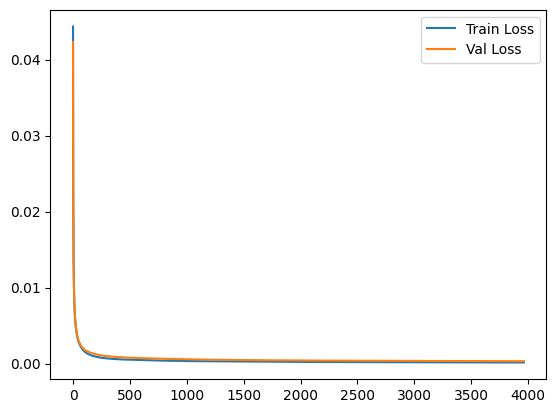

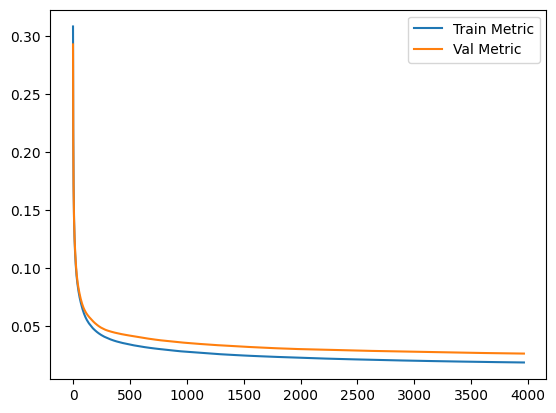

In [13]:
info = net.train(
    X_train, 
    y_train,
    X_val,
    y_val,
    10000,
    100,
    MEE()
)
plt.plot(info['tr_losses'], label='Train Loss')
plt.plot(info['val_losses'], label='Val Loss')
plt.legend()
plt.show()

plt.plot(info['tr_metrics'], label='Train Metric')
plt.plot(info['val_metrics'], label='Val Metric')
plt.legend()
plt.show()

In [15]:
print(net.statistics(X_train, y_train, MEE()))
print(net.statistics(X_val, y_val, MEE()))

(0.00014487693677929463, 0.018368050137334523)
(0.00031508128630263827, 0.026063237516497265)


In [ ]:
statistics = kfold_crossval(
    X=X_train,
    y=y_train,
    k=6,
    net=net,
    epochs=2500,
    patience=100,
    seed=seed,
    metric=MEE()
)

print(statistics)

Combination: [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.9) 0.001


Epochs:  12%|█▏        | 1207/10000 [01:51<13:34, 10.80it/s]


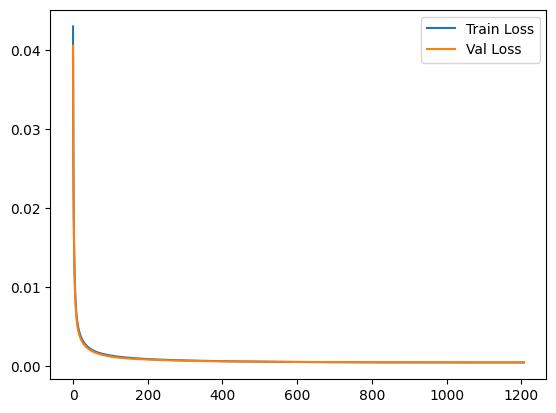

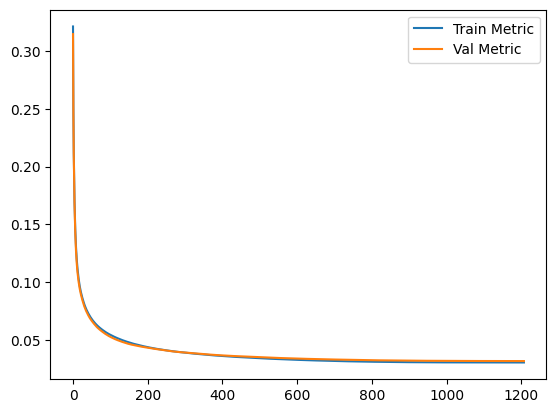

Fold 1 of 6 completed
Train Loss: 0.00041315516589726355
Train Metric: 0.03064352268204945
Val Loss: 0.0004276596299083042
Val Metric: 0.031953457737018284


Epochs:  23%|██▎       | 2261/10000 [03:41<12:36, 10.22it/s]


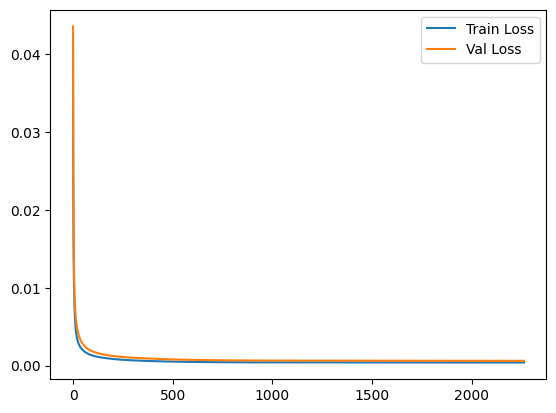

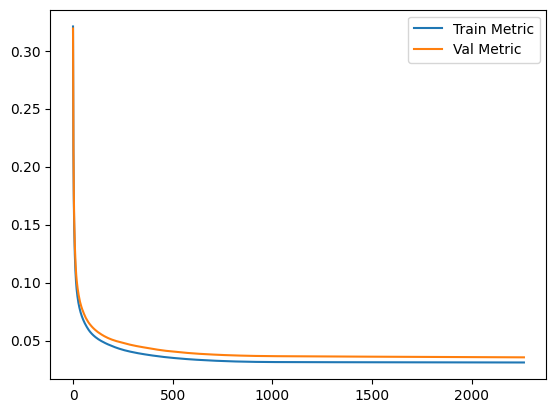

Fold 2 of 6 completed
Train Loss: 0.00040991588470285097
Train Metric: 0.031096050769788105
Val Loss: 0.000624563722830835
Val Metric: 0.03564310279582161


Epochs:  12%|█▏        | 1226/10000 [01:57<13:57, 10.48it/s]


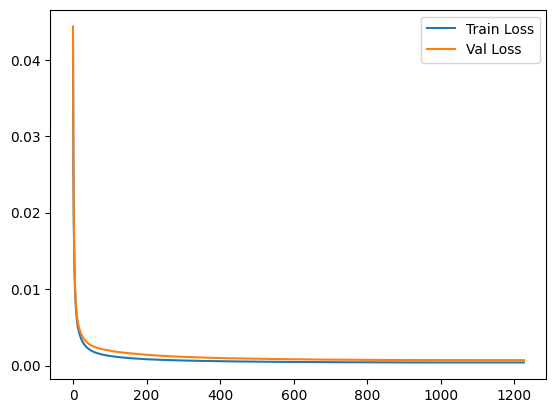

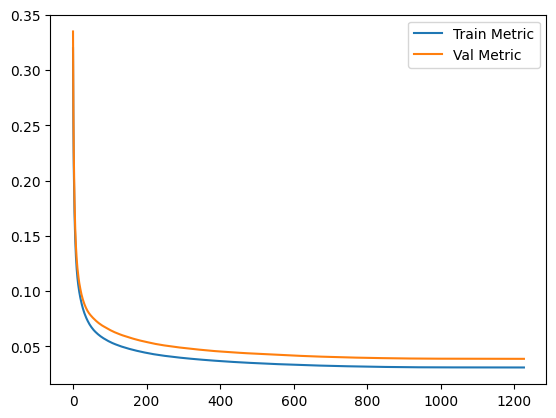

Fold 3 of 6 completed
Train Loss: 0.0004076964245744589
Train Metric: 0.03097515029505518
Val Loss: 0.0007205655566899638
Val Metric: 0.03883462970091697


Epochs:  14%|█▍        | 1394/10000 [02:20<14:25,  9.94it/s]


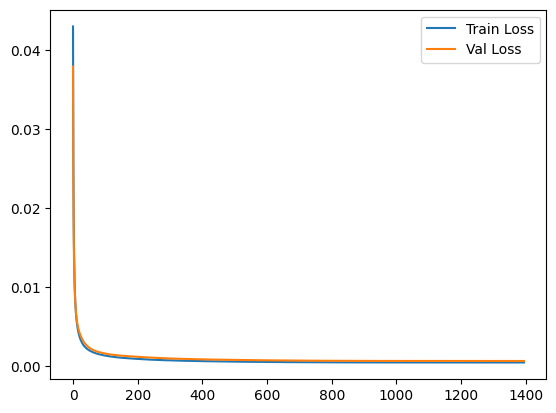

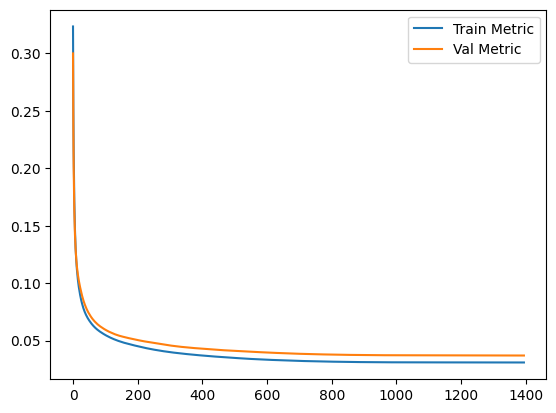

Fold 4 of 6 completed
Train Loss: 0.0004257465836987514
Train Metric: 0.03104708814894534
Val Loss: 0.000616119470171097
Val Metric: 0.03717864771879952


Epochs:  38%|███▊      | 3787/10000 [05:53<09:40, 10.70it/s]


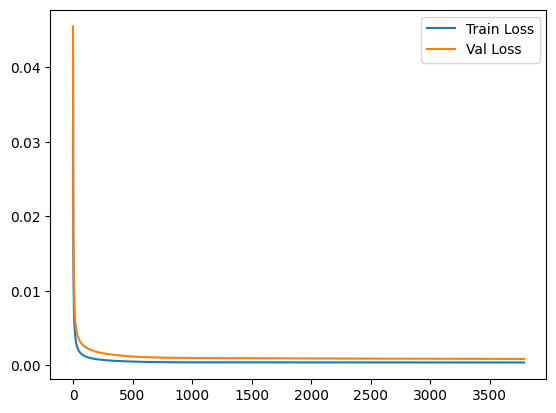

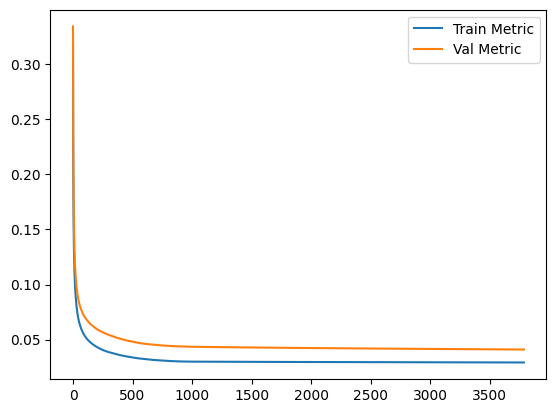

Fold 5 of 6 completed
Train Loss: 0.0003707495266859899
Train Metric: 0.029253359465957123
Val Loss: 0.0008521469635005265
Val Metric: 0.04111471757991996


Epochs:  24%|██▍       | 2420/10000 [03:04<09:37, 13.13it/s]


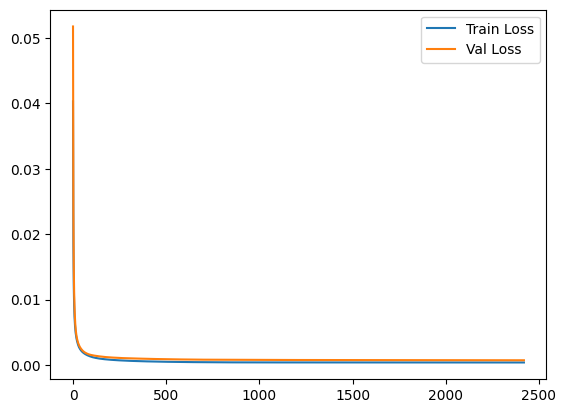

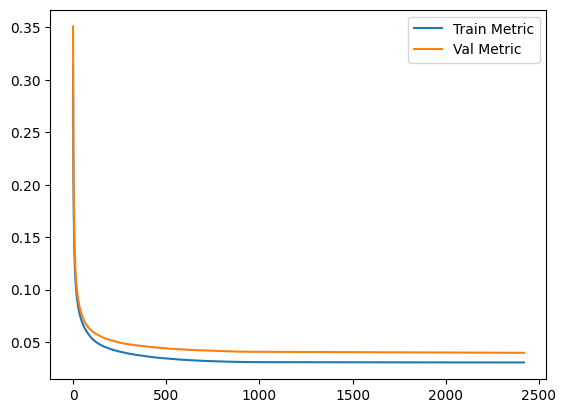

Fold 6 of 6 completed
Train Loss: 0.0003980955707985155
Train Metric: 0.03055667098613504
Val Loss: 0.0007431150594216522
Val Metric: 0.03989419006339071
Statistics: {'tr_loss': 0.00040422652605963833, 'tr_metric': 0.030595307057988377, 'val_loss': 0.0006640284004203965, 'val_metric': 0.037436457599311176}





In [4]:
hyperparameters = {
    'layers_sizes': [[32, 32, 3]],
    'activations': ["ReLU"], 
    'startings': ["Range_random"],
    'startings_range': [(-0.5, 0.5)],
    'regularizers': ["L2"],
    'regularizers_lambda': [1e-8],
    'momentums': [('Nesterov', 0.9)],
    'etas': [1e-3],
}

data_to_csv = grid_search(
    hyperparams=hyperparameters,
    X=X_train,
    y=y_train,
    k=6,
    metric=MEE(),
    loss=MSE(1),
    seed=6,
    verbose=True
)

In [ ]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

In [ ]:
# reshape ytrain eliminating last shape
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
y_train.shape

In [ ]:
# reshape Xtrain eliminating last shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_train.shape

In [ ]:
# use scikit-lear to make regression in 3d
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(32,32),
    activation='relu',
    solver='sgd',
    alpha=0,
    batch_size=1,
    learning_rate_init=1e-3,
    max_iter=2500,
    shuffle=True,
    random_state=6,
    verbose=True,
    momentum=0,
    beta_1= 0,
    beta_2= 0.,
    epsilon= 1,
    validation_fraction = 0,
    nesterovs_momentum=False
)

mlp.fit(X_train, y_train)
# print the learning curve
plt.plot(mlp.loss_curve_)
plt.show()

# print the mean error
print(MEE()(y_train, mlp.predict(X_train)))

In [ ]:
import itertools

# Define the hyperparameters as dictionaries
hyperparameters = {
    'losses': ["MSE"],
    'layers_sizes': [[32,32,3],[16,16,16,3]],
    'activations': ["ReLU"], 
    'startings': ["Range_random"],
    'startings_range': [(-0.5, 0.5)],
    'regularizers': ["L2"],
    'regularizers_lambda': [1e-6, 1e-8],
    'momentums': [('Nesterov', 1e-4), ('Standard', 1e-4)],
    'etas': [1e-4]
}

# Create a list of all the possible combinations using itertools.product
hyperparameter_combinations = list(itertools.product(*hyperparameters.values()))

all_dics = []
# Print the result or use it as needed
for combination in hyperparameter_combinations:
    hyperparameter_dict = dict(zip(hyperparameters.keys(), combination))
    print(hyperparameter_dict)
    all_dics.append(hyperparameter_dict)

In [ ]:
for i in all_dics:
    print(*i.values())

In [ ]:
losses_ = "MSE"

startings_ = []
startings_range_ = []
activations_ = []
regularizers_ = []
regularizers_lambda_ = []
momentums_ = []


for combination in all_dics:
    layers_sizes_ = combination['layers_sizes']
    startings_ = []
    activations_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    startings_range_ = []
    etas_ = combination['etas']
    for i in range(len(combination['layers_sizes'])):
        activations_.append(combination['activations'] if i != len(layers_sizes_)-1 else "Identity")
        startings_.append(combination['startings'])
        startings_range_.append(combination['startings_range'])
        regularizers_.append(combination['regularizers'])
        regularizers_lambda_.append(combination['regularizers_lambda'])
        momentums_.append(combination['momentums'])
    
    print(layers_sizes_)
    print(activations_)
    print(startings_)
    print(startings_range_)
    print(regularizers_)
    print(regularizers_lambda_)
    print(momentums_)
    print(etas_)
    print("\n")

In [ ]:
data_to_csv = [["Loss func","Size", "Activation", "Starting", "Range", "Regularizer", "lambda", "Momentum", "Eta", "tLoss", "tMetric", "vLoss", "vMetric"]]

In [ ]:
seed = 3
data_to_csv = [[]]
losses_ = "MSE"

for combination in all_dics:
    layers_sizes_ = combination['layers_sizes']
    activations_ = []
    startings_ = []
    startings_range_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    etas_ = combination['etas']
    for i in range(len(combination['layers_sizes'])):
        activations_.append(combination['activations'] if i != len(layers_sizes_)-1 else "Identity")
        startings_.append(combination['startings'])
        startings_range_.append(combination['startings_range'])
        regularizers_.append(combination['regularizers'])
        regularizers_lambda_.append(combination['regularizers_lambda'])
        momentums_.append(combination['momentums'])
    net = create_all_net(
        seed=seed,
        loss="MSE",
        batch_size=1,
        input_size=len(X_train[0]),
        num_layer=len(layers_sizes_),
        layers_size=layers_sizes_,
        activations=activations_,
        starting=startings_,
        starting_range=startings_range_,
        regularizers=regularizers_,
        regularizers_lambda=regularizers_lambda_,
        momentums=momentums_,
        eta=etas_
        )
    statistics = kfold_crossval(
        X=X_train,
        y=y_train,
        k=6,
        net=net,
        epochs=10000,
        patience=250,
        seed=seed,
        metric=MEE(),
        comb=combination
        )
    print(statistics)
    print("\n\n\n")
    data_to_csv.append(list(combination.values()) + list(statistics.values()))


In [ ]:
data_to_csv

In [11]:
import csv

csv_file_path = '../statistics/test.csv'
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data to the CSV file
    for row in data_to_csv:
        writer.writerow(row)    